In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
from keras.layers import Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,AveragePooling1D,GlobalAveragePooling1D,Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from math import sqrt
start = dt.datetime(2000,1,1)

# endDate , as per our convenience we can modify
end = dt.datetime.now()
startdate=end
company = input('STOCK : ')
df = yf.Ticker(company)

# pass the parameters as the taken dates for start and end
data =df.history(start=start,end=end)

data.head(5)

STOCK : BTC-USD


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [2]:
def preprocess_data(data, target_col, sequence_length=10):
    data=data.drop(['Dividends','Stock Splits'],axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
#     data_scaled = scaler.fit_transform(data[[target_col]])
    
    # Normalize the data
    data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    features, targets = [], []

    for i in range(len(data_scaled) - sequence_length):
        features.append(data_scaled[i:i + sequence_length])
        targets.append(data_scaled[i + sequence_length])

    features, targets = np.array(features), np.array(targets)
    

    return features, targets, scaler

In [3]:
target_col = 'Close'
sequence_length = 10
features, targets, scaler = preprocess_data(data, target_col, sequence_length)
print(f'Fearture: {features} , Targets: {targets} , Scaler: {scaler}')
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Fearture: [[[0.00414359]
  [0.00365546]
  [0.00321557]
  ...
  [0.00363714]
  [0.00346454]
  [0.00335845]]

 [[0.00365546]
  [0.00321557]
  [0.00342492]
  ...
  [0.00346454]
  [0.00335845]
  [0.00328567]]

 [[0.00321557]
  [0.00342492]
  [0.0032753 ]
  ...
  [0.00335845]
  [0.00328567]
  [0.00295417]]

 ...

 [[0.61244844]
  [0.63382471]
  [0.63580175]
  ...
  [0.62462117]
  [0.64512494]
  [0.64834361]]

 [[0.63382471]
  [0.63580175]
  [0.6195644 ]
  ...
  [0.64512494]
  [0.64834361]
  [0.65025417]]

 [[0.63580175]
  [0.6195644 ]
  [0.62416991]
  ...
  [0.64834361]
  [0.65025417]
  [0.6464203 ]]] , Targets: [[0.00328567]
 [0.00295417]
 [0.00292874]
 ...
 [0.65025417]
 [0.6464203 ]
 [0.64715183]] , Scaler: MinMaxScaler()


In [4]:
X_test.shape

(676, 10, 1)

In [5]:
#CNN MODEL
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))

# cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

In [6]:
# Apply the CNN model to the input
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoded_cnn = cnn_model(input_layer)
encoded_cnn.shape

TensorShape([None, 512])

In [7]:
# Reshape the output for LSTM
reshaped_output = Reshape((encoded_cnn.shape[1], 1))(encoded_cnn)
reshaped_output.shape

TensorShape([None, 512, 1])

In [8]:
# # Build the LSTM model on top of the reshaped output
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, input_shape=(reshaped_output.shape[1], reshaped_output.shape[2])))
# lstm_model.add(Dense(1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(reshaped_output.shape[1], reshaped_output.shape[2])))
lstm_model.add(Dropout(0.2))

# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=50))
# model.add(Dropout(0.2))

lstm_model.add(Dense(units=1))

In [9]:
# Apply the LSTM model on the reshaped output

final_output = lstm_model(reshaped_output)
final_output.shape

TensorShape([None, 1])

In [10]:
# Build the complete model
hybrid_model = Model(inputs=input_layer, outputs=final_output)

In [11]:
# Compile the model
hybrid_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [12]:
# Train the model
history=hybrid_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
68/68 [==============================] - 10s 129ms/step - loss: 0.0516 - mae: 0.1708 - val_loss: 0.0421 - val_mae: 0.1384
Epoch 2/50
68/68 [==============================] - 9s 126ms/step - loss: 0.0197 - mae: 0.1064 - val_loss: 0.0015 - val_mae: 0.0316
Epoch 3/50
68/68 [==============================] - 8s 119ms/step - loss: 0.0020 - mae: 0.0290 - val_loss: 4.5398e-04 - val_mae: 0.0161
Epoch 4/50
68/68 [==============================] - 8s 124ms/step - loss: 0.0013 - mae: 0.0223 - val_loss: 3.8053e-04 - val_mae: 0.0142
Epoch 5/50
68/68 [==============================] - 9s 126ms/step - loss: 0.0013 - mae: 0.0225 - val_loss: 4.2731e-04 - val_mae: 0.0157
Epoch 6/50
68/68 [==============================] - 8s 116ms/step - loss: 0.0012 - mae: 0.0214 - val_loss: 6.4319e-04 - val_mae: 0.0205
Epoch 7/50
68/68 [==============================] - 8s 111ms/step - loss: 0.0013 - mae: 0.0223 - val_loss: 2.8605e-04 - val_mae: 0.0113
Epoch 8/50
68/68 [==============================] - 8s 

In [13]:
test_loss, test_mae=hybrid_model.evaluate(X_test, y_test, verbose=1)

22/22 [==============================] - 1s 44ms/step - loss: 3.0322e-04 - mae: 0.0124


In [14]:
print(f'Test mae: {test_mae * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test mae: 1.24%
Test Loss: 0.0003


In [15]:
# def make_predictions(hybrid_model, X_test, scaler):
#     predictions = hybrid_model.predict(X_test)
#     predictions = scaler.inverse_transform(predictions)

#     return predictions
# predictions = make_predictions(hybrid_model, X_test, scaler)

# mse = mean_squared_error(scaler.inverse_transform(y_test), predictions)

# print(f'Mean Squared Error: {mse}')

In [16]:
# Extract loss and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the final accuracy
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]
print(f"Final Training loss: {final_train_loss * 100:.2f}%")
print(f"Final Validation loss: {final_val_loss * 100:.2f}%")

Final Training loss: 0.07%
Final Validation loss: 0.03%


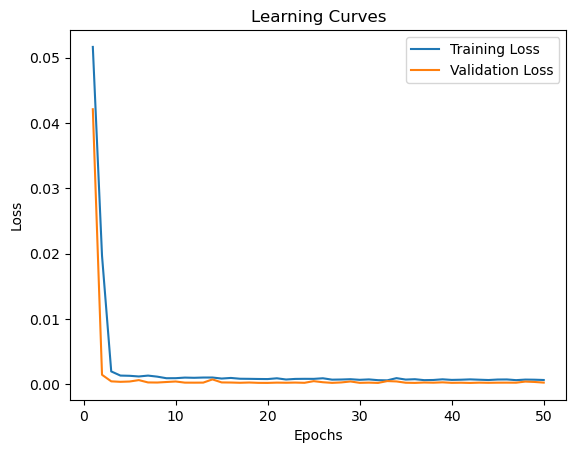

In [17]:
# Plot learning curves
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
loss, mae = hybrid_model.evaluate(X_test, y_test)

# Print the evaluation results
print(f'Mean Squared Error: {loss}')
print(f'Mean Absolute Error: {mae}')


22/22 [==============================] - 1s 36ms/step - loss: 3.0322e-04 - mae: 0.0124
Mean Squared Error: 0.00030321598751470447
Mean Absolute Error: 0.01236565038561821


In [19]:
# Predict on the test set
y_pred = hybrid_model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

22/22 [==============================] - 1s 37ms/step


In [20]:
y_pred_original.shape

(676, 1)

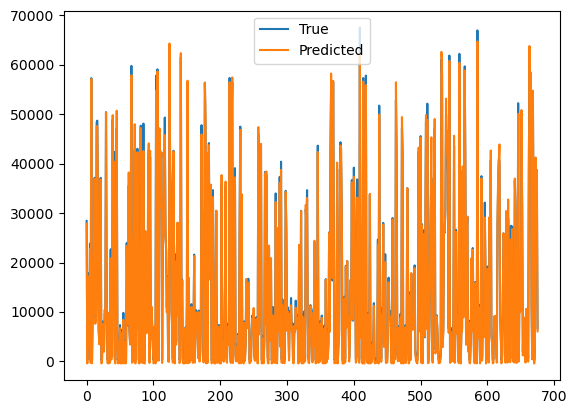

In [21]:
# Visualize predictions
plt.plot(y_test_original, label='True')
plt.plot(y_pred_original, label='Predicted')
plt.legend()
plt.show()

In [ ]:

import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, LSTM, Dropout
import matplotlib.pyplot as plt

start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()
startdate = end
company = input('STOCK : ')
df = yf.Ticker(company)
data = df.history(start=start, end=end)

def preprocess_data(data, target_col, sequence_length=10):
    data = data.drop(['Dividends', 'Stock Splits'], axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[[target_col]])

    features, targets = [], []

    for i in range(len(data_scaled) - sequence_length):
        features.append(data_scaled[i:i + sequence_length])
        targets.append(data_scaled[i + sequence_length])

    features, targets = np.array(features), np.array(targets)

    return features, targets, scaler

target_col = 'Close'
sequence_length = 10
features, targets, scaler = preprocess_data(data, target_col, sequence_length)
print(f'Feature: {features.shape} , Targets: {targets.shape} , Scaler: {scaler}')

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# CNN MODEL
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

# Apply the CNN model to the input
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoded_cnn = cnn_model(input_layer)

# Reshape the output for LSTM
reshaped_output = Reshape((encoded_cnn.shape[1], 1))(encoded_cnn)

# Build the LSTM model on top of the reshaped output
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(reshaped_output.shape[1], reshaped_output.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Apply the LSTM model on the reshaped output
final_output = lstm_model(reshaped_output)

# Build the complete model
hybrid_model = Model(inputs=input_layer, outputs=final_output)
# Compile the model
hybrid_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Train the model
history = hybrid_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_mae = hybrid_model.evaluate(X_test, y_test, verbose=1)
loss, mae = hybrid_model.evaluate(X_test, y_test)

# Print the evaluation results
print(f'Mean Squared Error: {loss}')
print(f'Mean Absolute Error: {mae}')

# Predict on the test set
y_pred = hybrid_model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_original = scaler.inverse_transform(y_pred[:, -1].reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test[:, -1].reshape(-1, 1))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual Closing Prices', marker='o')
plt.plot(data.index[-len(y_pred_original):], y_pred_original, label='Predicted Closing Prices', linestyle='dashed', marker='o')
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


STOCK : BTC-USD
Feature: (3376, 10, 1) , Targets: (3376, 1) , Scaler: MinMaxScaler()
Epoch 1/30
68/68 [==============================] - 11s 131ms/step - loss: 0.0407 - mae: 0.1445 - val_loss: 0.0021 - val_mae: 0.0306
Epoch 2/30
68/68 [==============================] - 9s 126ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 4.7783e-04 - val_mae: 0.0143
Epoch 3/30
68/68 [==============================] - 9s 134ms/step - loss: 0.0012 - mae: 0.0204 - val_loss: 2.6543e-04 - val_mae: 0.0106
Epoch 4/30
31/68 [============>.................] - ETA: 4s - loss: 0.0010 - mae: 0.0197  

In [29]:

# Inverse transform the predictions and true values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred[:, -1].reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test[:, -1].reshape(-1, 1))

# Calculate accuracy and error percentage
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
accuracy = 100 - (rmse / np.mean(y_test_inv)) * 100

print(f'Root Mean Squared Error: {rmse}')
print(f'Accuracy: {accuracy:.2f}%')

Root Mean Squared Error: 1258.612158210873
Accuracy: 91.10%
